In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import joblib

## Load the data

In [2]:
orders_df = pd.read_csv("./data/orders_dataset.csv")
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [3]:
orders_df = orders_df[(orders_df["order_status"] == "delivered")].reset_index(drop=True)

In [4]:
orders_df.order_status.value_counts()

delivered    96478
Name: order_status, dtype: int64

In [5]:
order_payments_df = pd.read_csv("./data/order_payments_dataset.csv")
order_payments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [6]:
new_orders_df = pd.merge(
    left=orders_df,
    right=order_payments_df,
    on="order_id",
    how="inner"
)
new_orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,1,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,3,voucher,1,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2,voucher,1,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,boleto,1,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1,credit_card,3,179.12


In [7]:
datetime_columns = [
    "order_purchase_timestamp", 
    "order_approved_at", 
    "order_delivered_carrier_date", 
    "order_delivered_customer_date", 
    "order_estimated_delivery_date"
]

for column in datetime_columns:
    new_orders_df[column] = pd.to_datetime(new_orders_df[column])

In [8]:
new_orders_df["order_purchase_timestamp"].dt.strftime("%Y-%m-%d")

0         2017-10-02
1         2017-10-02
2         2017-10-02
3         2018-07-24
4         2018-08-08
             ...    
100751    2017-03-09
100752    2018-02-06
100753    2017-08-27
100754    2018-01-08
100755    2018-03-08
Name: order_purchase_timestamp, Length: 100756, dtype: object

### Check the daily transaction

In [9]:
daily_orders_df = new_orders_df.groupby(by='order_purchase_timestamp').agg({
    "order_id": "nunique",
    "payment_value": "sum"
}).reset_index()

In [10]:
daily_orders_df.sort_values(by="order_purchase_timestamp")
daily_orders_df.rename(columns={
    "order_id": "order_count",
    "payment_value": "revenue"
}, inplace=True)

daily_orders_df.head()

,order_purchase_timestamp,order_count,revenue
0,2016-10-03 09:44:50,1,45.46
1,2016-10-03 16:56:50,1,39.09
2,2016-10-03 21:13:36,1,53.73
3,2016-10-03 22:06:03,1,133.46
4,2016-10-03 22:31:31,1,40.95


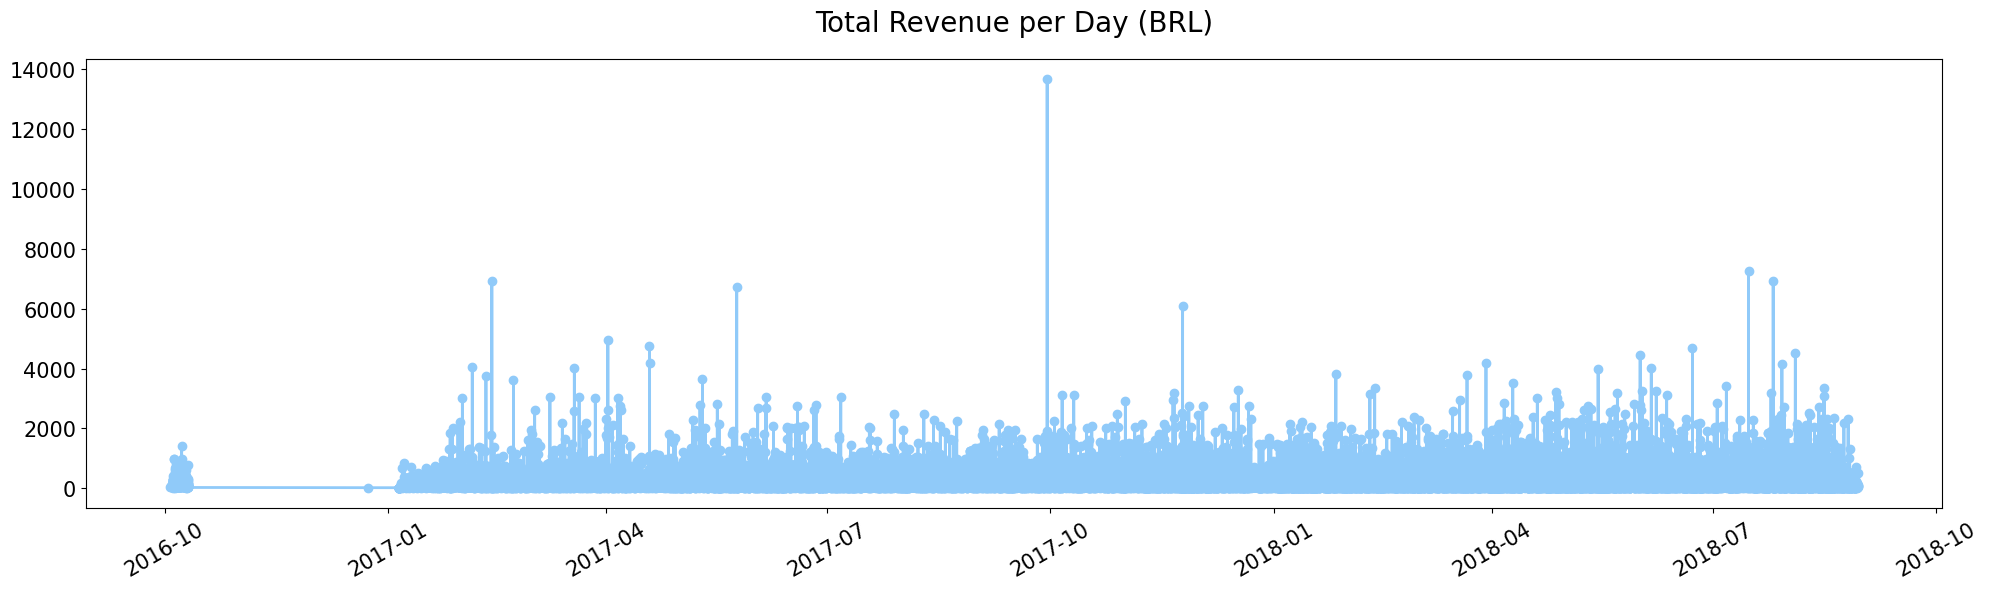

In [11]:
plt.figure(figsize=(20, 6))
plt.plot(
    daily_orders_df["order_purchase_timestamp"],
    daily_orders_df["revenue"],
    marker='o', 
    linewidth=2,
    color="#90CAF9"
)
plt.title("Total Revenue per Day (BRL)", loc="center", fontsize=20, pad=20)
labels, locations = plt.yticks()
plt.xticks(rotation=30,fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

### Check the mounthly transaction

In [12]:
monthly_orders_df = new_orders_df.resample('M', on='order_purchase_timestamp').agg({
    "order_id": "nunique",
    "payment_value": "sum"
})

monthly_orders_df.index = monthly_orders_df.index.strftime('%Y-%m')
# monthly_orders_df = monthly_orders_df.reset_index()
monthly_orders_df.sort_values(by="order_purchase_timestamp")
monthly_orders_df.rename(columns={
    "order_id": "order_count",
    "payment_value": "revenue"
}, inplace=True)

monthly_orders_df.head()

,order_count,revenue
order_purchase_timestamp,,
2016-10,265,46566.71
2016-11,0,0.00
2016-12,1,19.62
2017-01,750,127545.67
2017-02,1653,271298.65


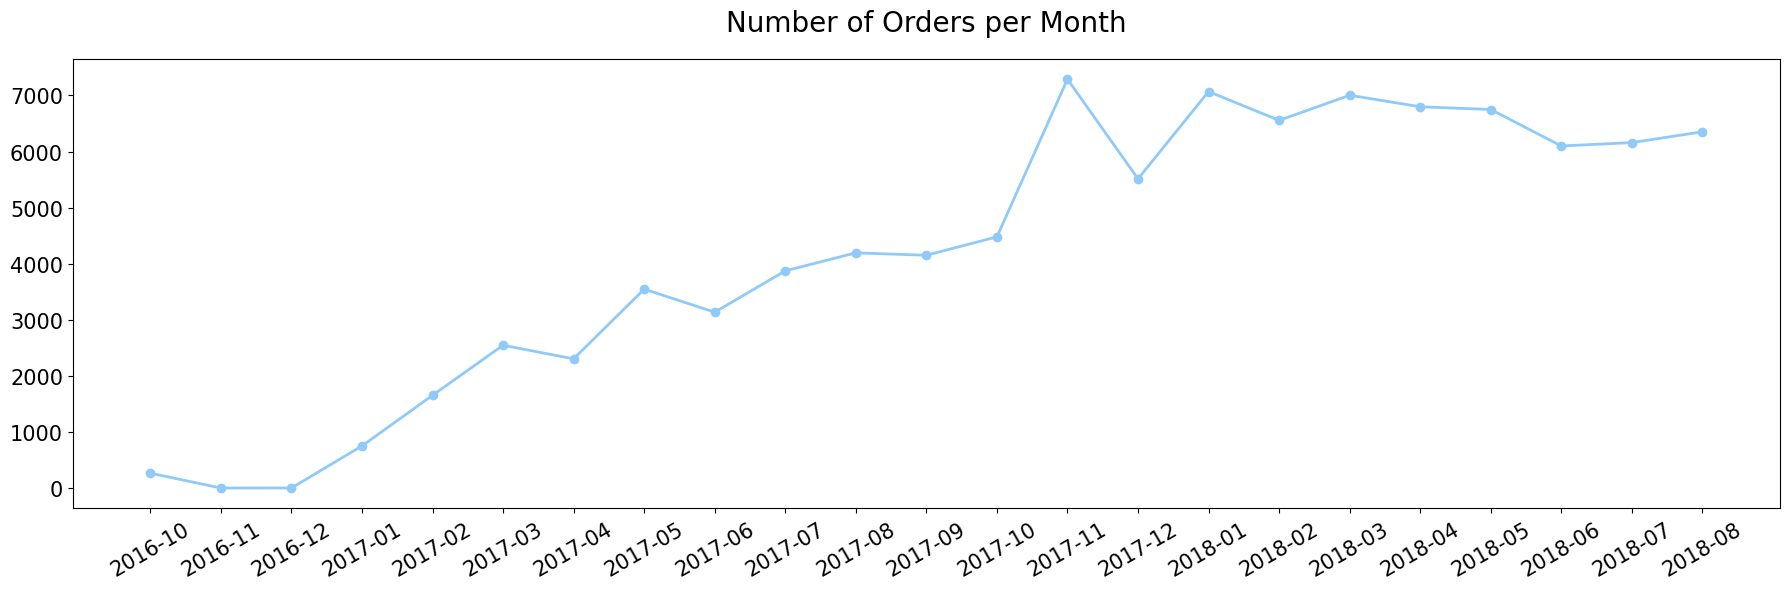

In [13]:
plt.figure(figsize=(18, 6))
plt.plot(
    monthly_orders_df.index,
    monthly_orders_df["order_count"],
    marker='o', 
    linewidth=2,
    color="#90CAF9"
)
plt.title("Number of Orders per Month", loc="center", fontsize=20, pad=20)
labels, locations = plt.yticks()
plt.xticks(rotation=30,fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

## Preprocessing the data

In [14]:
scaler = MinMaxScaler()
y = np.asarray(monthly_orders_df["order_count"])
y = y.reshape(-1,1)
scaler.fit(y)
monthly_orders_df["norm_order_count"] = scaler.transform(y)

In [15]:
monthly_orders_df["norm_order_count"]

order_purchase_timestamp
2016-10    0.036356
2016-11    0.000000
2016-12    0.000137
2017-01    0.102895
2017-02    0.226780
2017-03    0.349293
2017-04    0.315956
2017-05    0.486486
2017-06    0.430100
2017-07    0.531211
2017-08    0.575250
2017-09    0.569351
2017-10    0.614350
2017-11    1.000000
2017-12    0.756345
2018-01    0.969818
2018-02    0.899300
2018-03    0.960763
2018-04    0.932638
2018-05    0.925916
2018-06    0.836740
2018-07    0.844972
2018-08    0.871313
Name: norm_order_count, dtype: float64

In [16]:
def split_sequence(seq, n_steps):
    X, y = [], []
    for i in range(len(seq)-(n_steps+1)):
        v = seq.iloc[i:(i+n_steps)]
        X.append(v)
        y.append(seq.iloc[i + n_steps])
    return np.array(X), np.array(y)

In [17]:
data = monthly_orders_df["norm_order_count"]

X, y = split_sequence(data, n_steps=3)

In [18]:
data

order_purchase_timestamp
2016-10    0.036356
2016-11    0.000000
2016-12    0.000137
2017-01    0.102895
2017-02    0.226780
2017-03    0.349293
2017-04    0.315956
2017-05    0.486486
2017-06    0.430100
2017-07    0.531211
2017-08    0.575250
2017-09    0.569351
2017-10    0.614350
2017-11    1.000000
2017-12    0.756345
2018-01    0.969818
2018-02    0.899300
2018-03    0.960763
2018-04    0.932638
2018-05    0.925916
2018-06    0.836740
2018-07    0.844972
2018-08    0.871313
Name: norm_order_count, dtype: float64

In [19]:
X.shape

(19, 3)

In [20]:
y.shape

(19,)

## Build & train the model

In [21]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(
    units=32, return_sequences=True, input_shape=(X.shape[1], 1),
    activation="relu"
))
model.add(tf.keras.layers.LSTM(units=16, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation="relu"))

optimizer = tf.keras.optimizers.Adam(lr=1e-4)
loss=tf.keras.losses.Huber()

model.compile(loss=loss, optimizer=optimizer, metrics = ["mse", "mae"])

model.build(input_shape=(None, 3, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 32)             4352      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 7,505
Trainable params: 7,505
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(X, y, epochs=500)

Epoch 1/500
1/1 [==============================] - 3s 3s/step - loss: 0.2393 - mse: 0.4785 - mae: 0.6384
Epoch 2/500
1/1 [==============================] - 0s 10ms/step - loss: 0.2373 - mse: 0.4745 - mae: 0.6354
Epoch 3/500
1/1 [==============================] - 0s 16ms/step - loss: 0.2351 - mse: 0.4703 - mae: 0.6321
Epoch 4/500
1/1 [==============================] - 0s 24ms/step - loss: 0.2329 - mse: 0.4658 - mae: 0.6288
Epoch 5/500
1/1 [==============================] - 0s 16ms/step - loss: 0.2306 - mse: 0.4612 - mae: 0.6253
Epoch 6/500
1/1 [==============================] - 0s 9ms/step - loss: 0.2283 - mse: 0.4566 - mae: 0.6217
Epoch 7/500
1/1 [==============================] - 0s 10ms/step - loss: 0.2259 - mse: 0.4518 - mae: 0.6179
Epoch 8/500
1/1 [==============================] - 0s 9ms/step - loss: 0.2234 - mse: 0.4468 - mae: 0.6141
Epoch 9/500
1/1 [==============================] - 0s 8ms/step - loss: 0.2208 - mse: 0.4416 - mae: 0.6101
Epoch 10/500
1/1 [========================

## Evaluation

In [23]:
prediction = model.predict(X)

1/1 [==============================] - 0s 377ms/step


In [24]:
prediction_inverse = scaler.inverse_transform(prediction)
prediction_inverse 

array([[1506.148 ],
       [1503.6813],
       [1765.2135],
       [2369.4253],
       [2979.8228],
       [3543.9993],
       [3789.8472],
       [4518.712 ],
       [4623.343 ],
       [5281.3916],
       [5584.3765],
       [5931.116 ],
       [6349.4126],
       [6568.0386],
       [6563.5093],
       [6724.402 ],
       [6718.2656],
       [6731.6226],
       [6618.8853]], dtype=float32)

In [25]:
y = y.reshape(-1,1)

In [26]:
result_df = pd.DataFrame({
    "Date": np.asarray(data.iloc[3:-1].index),
    "order_count": scaler.inverse_transform(y).flatten(),
    "order_count_predicted": prediction_inverse.flatten() 
})

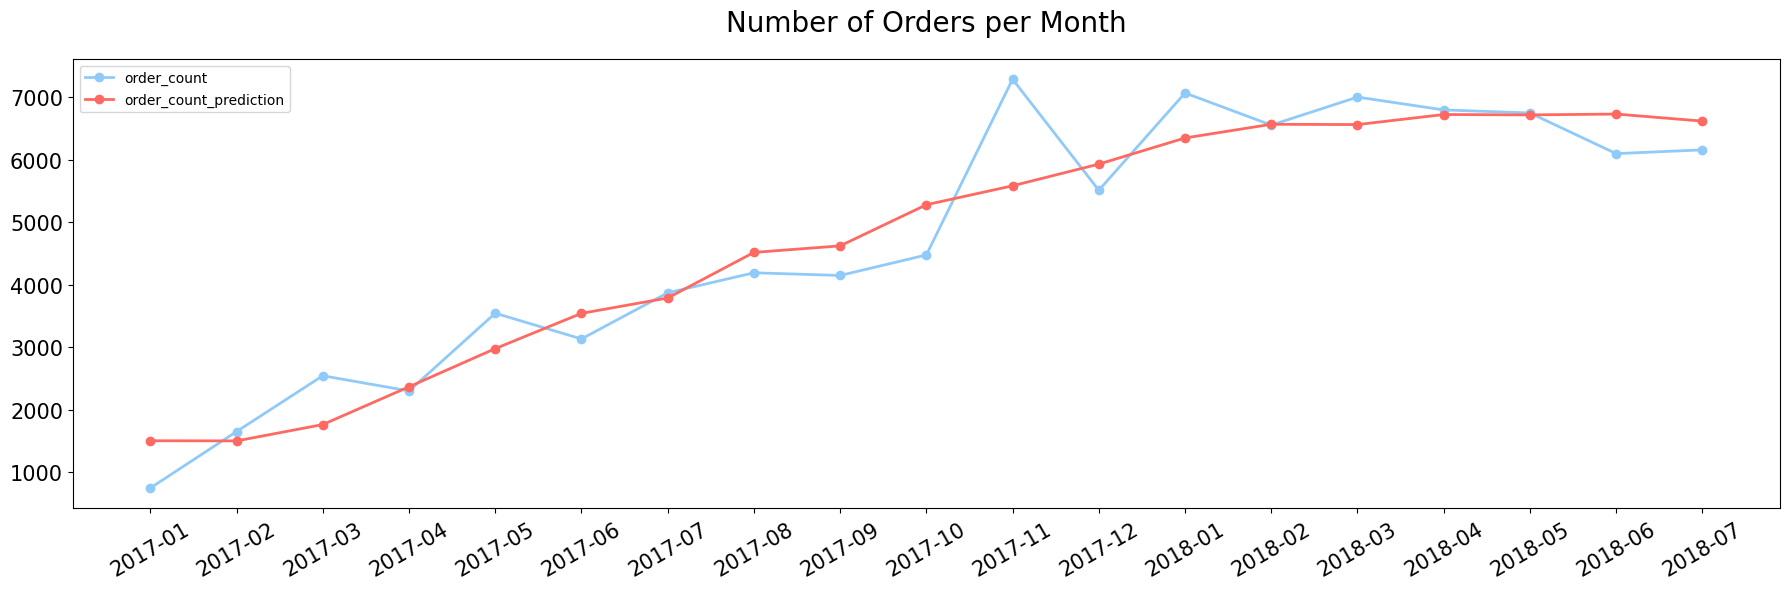

In [36]:

plt.figure(figsize=(18, 6))
plt.plot(
    result_df["Date"],
    result_df["order_count"],
    marker='o', 
    linewidth=2,
    color="#90CAF9"
)
plt.plot(
    result_df["Date"],
    result_df["order_count_predicted"],
    marker='o', 
    linewidth=2,
    color="#ff6961"
)
plt.title("Number of Orders per Month", loc="center", fontsize=20, pad=20)
labels, locations = plt.yticks()
plt.legend(['order_count', 'order_count_prediction'], loc="upper left")
plt.xticks(rotation=30,fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig("images/sales-prediction.png")
plt.show()

## Save model

In [28]:
import os

model_version = "1"
model_save = "sales-prediction"
model_path = os.path.join("models", model_save, model_version)
tf.saved_model.save(model, model_path)


INFO:tensorflow:Assets written to: models\sales-prediction\1\assets


INFO:tensorflow:Assets written to: models\sales-prediction\1\assets
